## Chapter 5
# Detection Using Cross Correlation With Whistler Kernel

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import h5py
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from sample_detector import SampleDetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)

## **5.3 Spectrogram**

**Cropped spectrogram**

2013-04-22UT01:28:03.48279656.marion.vr2


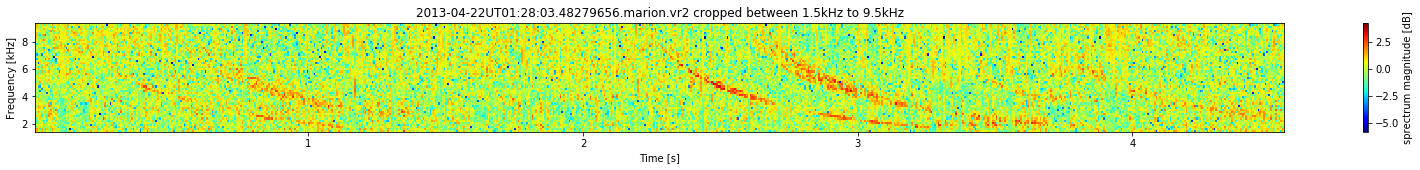

In [10]:
file = np.random.choice(database.get_train(),1)[0]
# file '2013-05-20UT16:02:23.18782156.marion.vr2'
# file = '2013-07-13UT17:44:16.56931930.marion.vr2'
# file = '2013-09-01UT15:04:07.94419414.marion.vr2'
file = '2013-04-22UT01:28:03.48279656.marion.vr2'
print(file)
sample = SampleDetector(dataset_loc, site, file)
freq_size = 4

transforms = ['slice', 'zscore']
transforms_params = [[1.5,9.5], ['None']]
sample.spectrogram_with_axis(log10=True)
size = (freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
sample.apply_transform(transforms, transforms_params)
sample.spectrogram_plot(figsize=size, xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                           xaxis=True, yaxis=True,
                           title=sample.get_file()+" cropped between 1.5kHz to 9.5kHz", cmap='jet', cmap_show=True)

## **5.4 Detector**

In [6]:
import multiprocessing as mp
from sklearn import mixture
import scipy.stats as stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

site = 'marion'
components = 1
dataset = Dataset(dataset_loc, site)

transforms = ['zscore']
transforms_params = [['None']]
cut_params=[1,0.2,8,1.5,0.1]
# database.create_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
#                               cut_params=cut_params, verbose=True, noise=True, train=True, test=False)
X,Y = database.load_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
                              cut_params=cut_params, verbose=True, noise=True, test=False)
w_ix, n_ix = np.argwhere(Y==1), np.argwhere(Y==0)

100%|██████████| 1000/1000 [00:05<00:00, 174.54it/s]


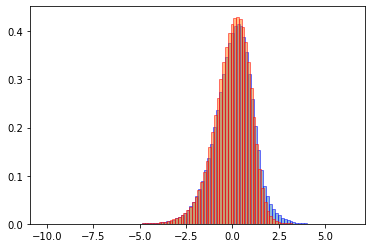

In [7]:
specs, noise = [], []
i = 1000
for s in tqdm(X[:i]):
    specs = np.concatenate((specs,s.flatten()))
for n in (X[n_ix][:i]):
    noise = np.concatenate((noise,n.flatten()))
plt.figure()
plt.hist(specs, bins=100, histtype='bar', density=True, ec='blue', alpha=0.5)
plt.hist(noise, bins=100, histtype='bar', density=True, ec='red', alpha=0.5)
plt.show()

In [2]:
whistlers = whistlers.reshape(-1,1)

# create Gaussian mixture of the data
g = mixture.GaussianMixture(n_components=components,covariance_type='full')
g.fit(whistlers)
weights, means, covars = g.weights_, g.means_, g.covariances_
print(components, weights, means, covars)
plt.figure()
legend = [Patch(facecolor='cornflowerblue', edgecolor='b',label='spectrogram\'s histogram'),
                  Line2D([0], [0], color='red', lw=3, label='gaussian distribution[s]')]
plt.hist(specs, bins=100, histtype='bar', density=True, ec='blue', alpha=0.5)
f_axis = whistlers.copy().ravel()
f_axis.sort()
for i in range(components):
    plt.plot(f_axis,weights[i]*stats.norm.pdf(f_axis,means[i],np.sqrt(covars[i])).ravel(), c='red')
plt.xlabel('spectrogram magnitude [dB]')
plt.legend(handles=legend, loc='upper left')
plt.title('Guassian distribution[s] of sprectrogram')
plt.show()

/home/othniel/wdml/data/databases/awdEvents1/marion/marion_h5/['zscore']_[['None']]_[1, 0.2, 8, 1.5, 0.1]_True/train
samples:  11149


 91%|█████████▏| 7609/8318 [05:00<00:56, 12.61it/s]

KeyboardInterrupt: 